In [1]:
# Standard library imports
from pathlib import Path
import os
import sys
import math
import itertools
from typing import List, Union, Sequence


# Third-party library imports
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from numpy import ndarray
from tqdm import tqdm
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from torch_geometric.data import Data
from torch_geometric.nn import ChebConv
from torch_geometric.nn.conv import GeneralConv

# Project-specific import
from Utils_GAN.classes import DynamicGraphTemporalSignal, GConvGRU, BoidDatasetLoader,RecurrentGCN
from Utils_GAN.classes import Encoder,Decoder,GraphSeqGenerator
from Utils_GAN.classes import GraphSeqDiscriminator,GraphSeqGenerator


from Utils_GAN.subfunctions import temporal_signal_split, train,plot_predictions,test,create_video_from_images
from Utils_GAN.subfunctions import train_generator,test_generator,test_generator_plot

### For Now: Grabbing Parts of Pytorch Geometric Temporal As Having Difficulty Setting Up The Environment For It

## Set Up BoidDatasetLoader To Load Entire Dataset
Following Example of EnglandCovidDatasetLoader from Pytorch Geometric Temporal

In [2]:
# reset kernel if not working
loader = BoidDatasetLoader()
dataset = loader.get_dataset()
dataset.snapshot_count

9999

In [4]:
# reset kernel if not working
loader = BoidDatasetLoader()
dataset = loader.get_dataset()
dataset.snapshot_count

9999

In [3]:
loader.min_features[0:2], loader.max_features[0:2]

(array([ 0.77037874, 10.09544699]), array([997.09113397, 990.39823977]))

# Split Dataset Into Training and Testing

In [4]:
train_dataset, test_dataset = temporal_signal_split(dataset)

train_dataset.snapshot_count, test_dataset.snapshot_count

(7999, 2000)

In [6]:
train_dataset, test_dataset = temporal_signal_split(dataset)

train_dataset.snapshot_count, test_dataset.snapshot_count

(7999, 2000)

## Create GConvGRU For Recurrent Layer In Our GNN

## Basic Graph Recurrent Neural Network

In [5]:
#  Training a basic model for tesiting purpose
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(3):
    for seq_start in tqdm(range(0, train_dataset.snapshot_count - 5, 5)):
        h_t_prev = None
        for i in range(5):
            snapshot = train_dataset[seq_start+i]
            y_hat, h_t = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h_t_prev)
            h_t_prev = h_t
        cost = F.mse_loss(y_hat, snapshot.y)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()


  6%|▌         | 96/1599 [00:05<01:30, 16.61it/s]


KeyboardInterrupt: 

## Training

In [6]:
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(train_dataset, 10, model, optimizer)

Epoch: 1/10


Training:   0%|          | 39/7991 [00:03<11:42, 11.32it/s]


KeyboardInterrupt: 

  1%|          | 11/1992 [00:04<12:50,  2.57it/s]


KeyboardInterrupt: 

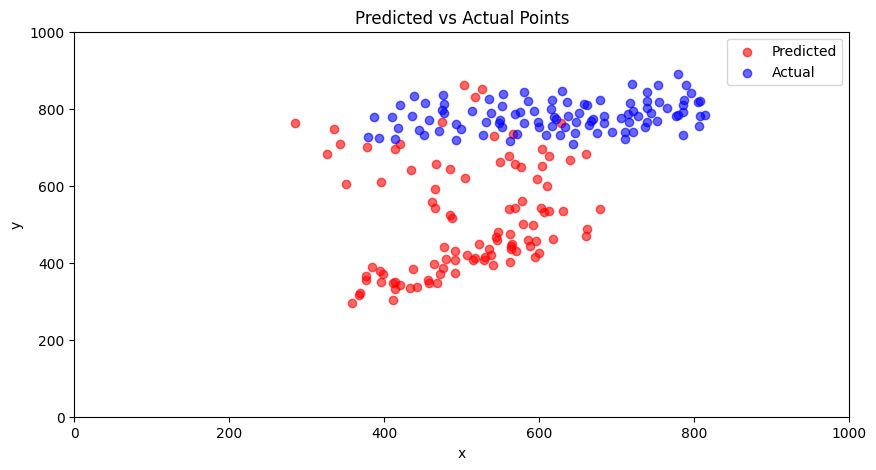

In [7]:
test(test_dataset, model,loader=loader)

In [8]:
import cv2
import os
import re

# Example usage
create_video_from_images('../generator_test_plots_at_epoch_30', 'generator_test_plots_at_epoch_30.mp4', fps=30)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../generator_test_plots_at_epoch_30'

In [6]:
create_video_from_images('../generator2_test_plots_at_epoch_30', 'generator2_test_plots_at_epoch_30.mp4', fps=30)

## Working on GAN [Generator: (Encoder, Decoder)] [Discriminator: (Encoder)]

In [9]:
generator = generator = GraphSeqGenerator(node_feat_dim=4,
                              enc_hidden_dim=32,
                              enc_latent_dim=16,
                              dec_hidden_dim=32,
                              pred_horizon=8,
                              min_max_x=(loader.min_features[0], loader.max_features[0]),
                              min_max_y=(loader.min_features[1], loader.max_features[1]),
                              min_max_edge_weight=(loader.min_edge_weight, loader.max_edge_weight),
                              visualRange=75,
                            )

device = torch.device('cpu')

generator.to(device)

GraphSeqGenerator(
  (encoder): Encoder(
    (recurrent): GConvGRU(
      (conv_x_z): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_r): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_h): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
    )
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (recurrent): GConvGRU(
      (conv_x_z): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_r): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_h): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
    )
    (linear): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [10]:
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

train_generator(train_dataset, 10, generator, optimizer, horizon=generator.out_steps)

Epoch: 1/10


Training:   0%|          | 7/7984 [00:03<1:09:32,  1.91it/s]


KeyboardInterrupt: 

In [11]:
test_generator(test_dataset, generator, horizon=generator.out_steps)

Testing:   1%|          | 24/1985 [00:08<11:20,  2.88it/s]


KeyboardInterrupt: 

Testing:   0%|          | 0/1985 [00:00<?, ?it/s]

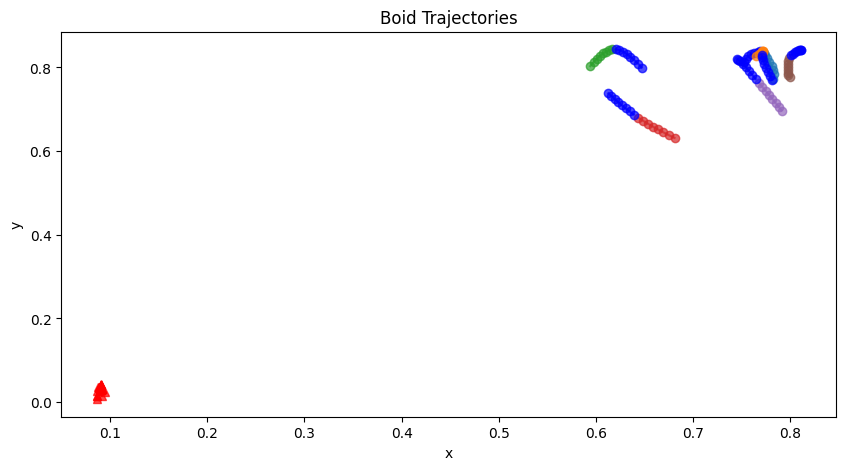

Testing:   0%|          | 1/1985 [00:00<19:43,  1.68it/s]

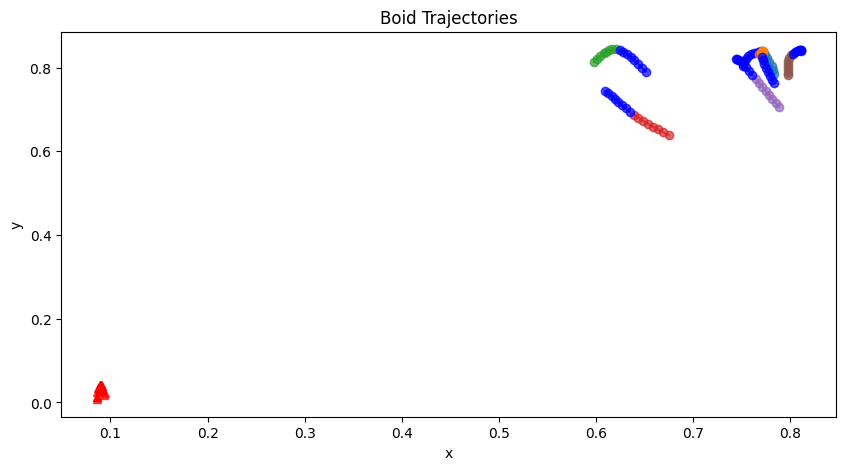

Testing:   0%|          | 2/1985 [00:01<19:18,  1.71it/s]

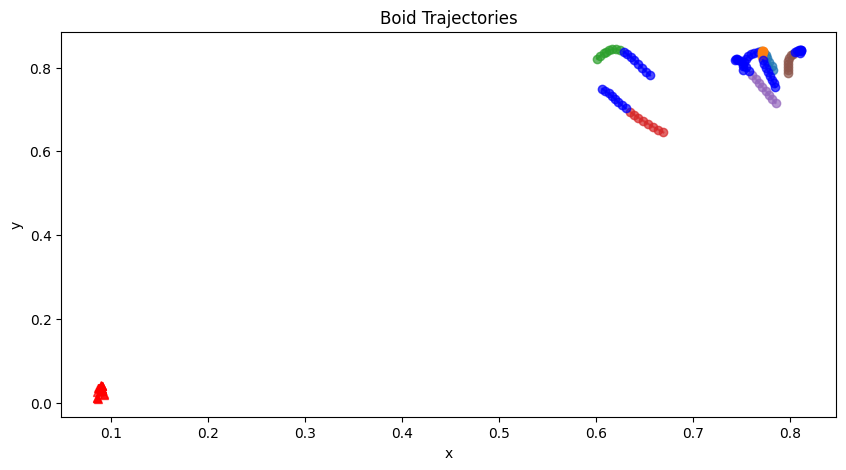

Testing:   0%|          | 3/1985 [00:01<19:34,  1.69it/s]

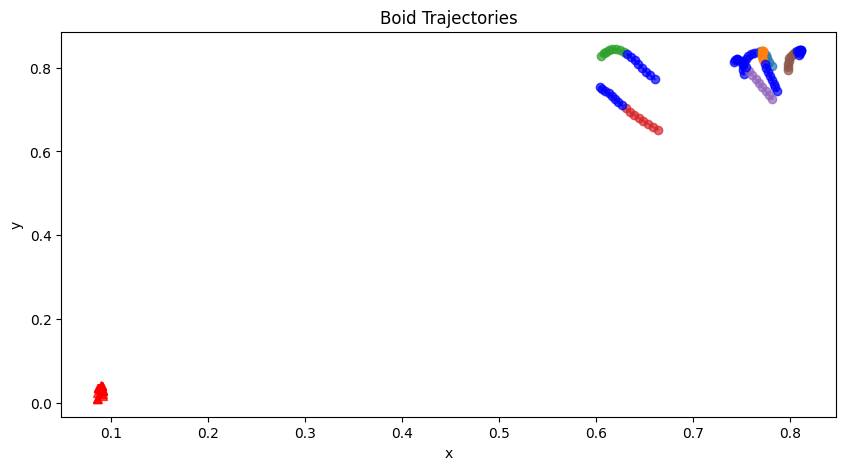

Testing:   0%|          | 4/1985 [00:02<19:21,  1.71it/s]

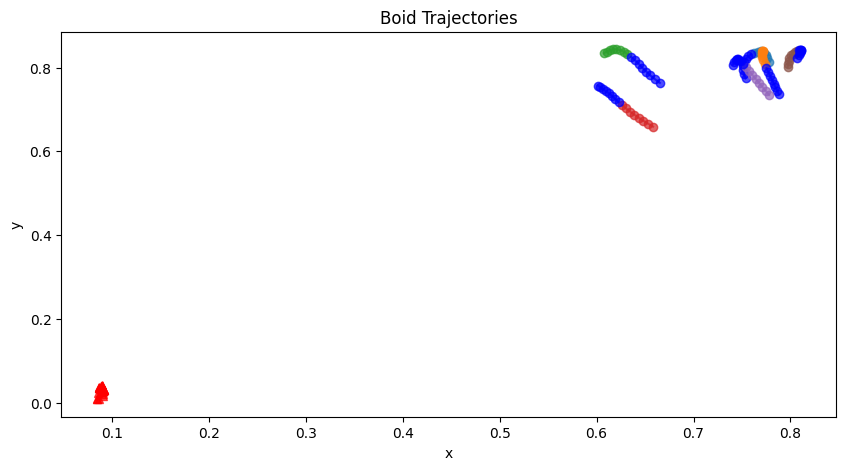

Testing:   0%|          | 5/1985 [00:02<19:20,  1.71it/s]

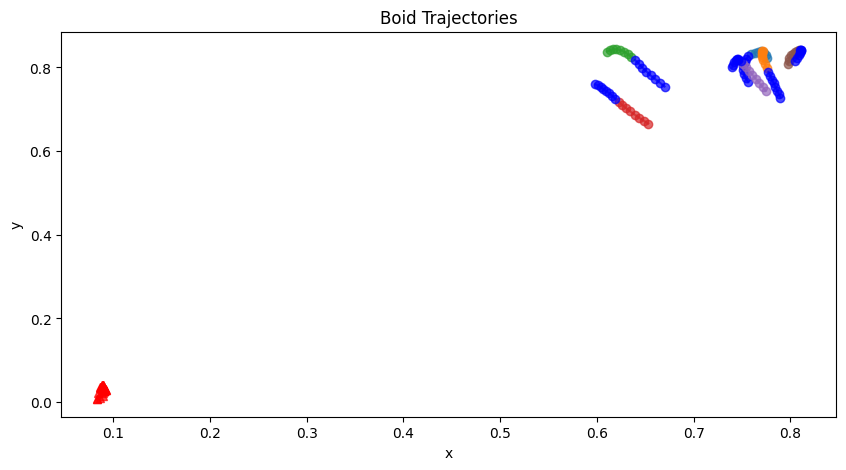

Testing:   0%|          | 6/1985 [00:03<19:07,  1.72it/s]

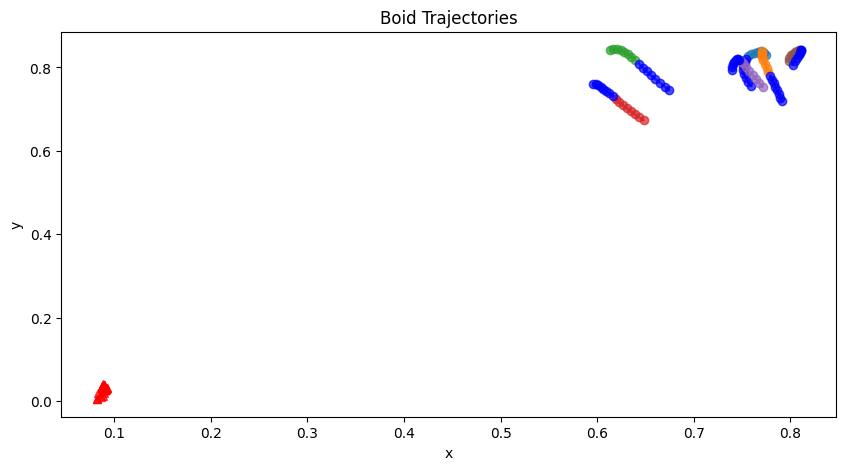

Testing:   0%|          | 7/1985 [00:04<21:41,  1.52it/s]


KeyboardInterrupt: 

In [12]:
test_generator_plot(test_dataset, generator, horizon=generator.out_steps)

In [11]:
def test_generator(test_data, generator, window=8, delay=0, horizon=1, stride=1):
    """
    Tests the given generator model using the provided test data.

    Args:
        test_data (Dataset): The dataset containing the test data.
        generator (nn.Module): The generator model to be tested.
        window (int, optional): The size of the input sequence window. Defaults to 8.
        delay (int, optional): The delay between the input sequence and the target sequence. Defaults to 0.
        horizon (int, optional): The prediction horizon. Defaults to 1.
        stride (int, optional): The stride for iterating over the test data. Defaults to 1.

    Returns:
        float: The average loss over the test dataset.
    """
    total_timesteps = test_data.snapshot_count
    sample_span = window + delay + horizon

    generator.eval()
    total_loss = 0
    with torch.no_grad():
        for start in tqdm(range(0, total_timesteps - sample_span + 1, stride), desc='Testing'):
            input_seq = test_data[start:start + window]
            target_seq = test_data[start + window + delay: start + window + delay + horizon]
            predictions = generator(input_seq, None, None)
            predictions = torch.stack(predictions, dim=0)
            target_seq = torch.stack([target_seq[i].x for i in range(target_seq.snapshot_count)], dim=0)
            cost = torch.mean((predictions - target_seq) ** 2)
            total_loss += cost.item()

    average_loss = total_loss / (total_timesteps - sample_span + 1)
    print('Testing Loss: ', average_loss)
    return average_loss


In [17]:
test_generator(test_dataset, generator, horizon=generator.out_steps)

NameError: name 'test_generator' is not defined

In [24]:
def test_generator_plot(test_data, generator, window=8, delay=0, horizon=1, stride=1, boid_indices=[0,1,2,3, 4, 5]):
    """
    Tests the given generator model using the provided test data and plots the trajectories.

    Args:
        test_data (Dataset): The dataset containing the test data.
        generator (nn.Module): The generator model to be tested.
        window (int, optional): The size of the input sequence window. Defaults to 8.
        delay (int, optional): The delay between the input sequence and the target sequence. Defaults to 0.
        horizon (int, optional): The prediction horizon. Defaults to 1.
        stride (int, optional): The stride for iterating over the test data. Defaults to 1.
        boid_indices (list, optional): List of boid indices to plot. Defaults to [0, 1, 2].

    Returns:
        None
    """
    total_timesteps = test_data.snapshot_count
    sample_span = window + delay + horizon

    generator.eval()
    with torch.no_grad():
        for start in tqdm(range(0, total_timesteps - sample_span + 1, stride), desc='Testing'):
            input_seq = test_data[start:start + window]
            target_seq = test_data[start + window + delay: start + window + delay + horizon]
            predictions = generator(input_seq, None, None)
            predictions = torch.stack(predictions, dim=0)
            target_seq = torch.stack([target_seq[i].x for i in range(target_seq.snapshot_count)], dim=0)
    
            boids_history = []
            boids_future = []
            boids_pred_future = []
            for boid_idx in boid_indices:
                boid_idx_actual_x = [target_seq[i, boid_idx, 0].item() for i in range(target_seq.shape[0])]
                boid_idx_actual_y = [target_seq[i, boid_idx, 1].item() for i in range(target_seq.shape[0])]
                boid_idx_pred_x = [pred[boid_idx, 0].item() for pred in predictions]
                boid_idx_pred_y = [pred[boid_idx, 1].item() for pred in predictions]
                boid_idx_hist_x = [input_seq[i].x[boid_idx, 0].item() for i in range(input_seq.snapshot_count)]
                boid_idx_hist_y = [input_seq[i].x[boid_idx, 1].item() for i in range(input_seq.snapshot_count)]

                boids_history.append((boid_idx_hist_x, boid_idx_hist_y))
                boids_future.append((boid_idx_actual_x, boid_idx_actual_y))
                boids_pred_future.append((boid_idx_pred_x, boid_idx_pred_y))

            def plot_boid_trajectories(boid_indices, boids_history, boids_future, boids_pred_future):
                """
                Plots the actual paths vs the predicted paths for the given boid indices.

                Args:
                    boid_indices (list): List of boid indices to plot.
                    boids_history (list): List of tuples containing historical x and y coordinates for each boid.
                    boids_future (list): List of tuples containing actual future x and y coordinates for each boid.
                    boids_pred_future (list): List of tuples containing predicted future x and y coordinates for each boid.

                Returns:
                    None
                """
                plt.figure(figsize=(10, 5))
                for i, boid_idx in enumerate(boid_indices):
                    hist_x, hist_y = boids_history[i]
                    actual_x, actual_y = boids_future[i]
                    pred_x, pred_y = boids_pred_future[i]

                    plt.plot(hist_x, hist_y, label=f'Boid {boid_idx} History', linestyle='-', marker='o', alpha=0.7)
                    plt.plot(actual_x, actual_y, label=f'Boid {boid_idx} Actual Future', linestyle='-', marker='o', color='blue', alpha=0.7)
                    plt.plot(pred_x, pred_y, label=f'Boid {boid_idx} Predicted Future', linestyle='-', marker='^', color='red', alpha=0.7)

                plt.xlabel('x')
                plt.ylabel('y')
                plt.title('Boid Trajectories')
                plt.show()

            # Call the function to plot the trajectories
            plot_boid_trajectories(boid_indices, boids_history, boids_future, boids_pred_future)


Testing:   0%|          | 0/1985 [00:00<?, ?it/s]

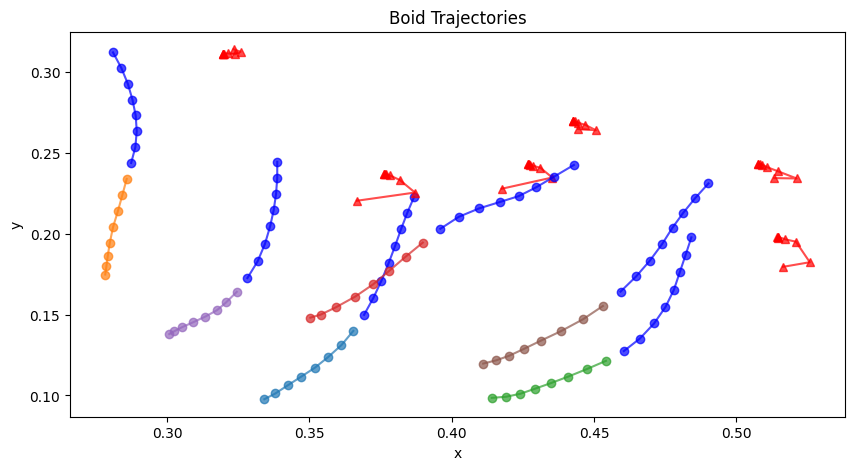

Testing:   0%|          | 1/1985 [00:00<04:48,  6.87it/s]

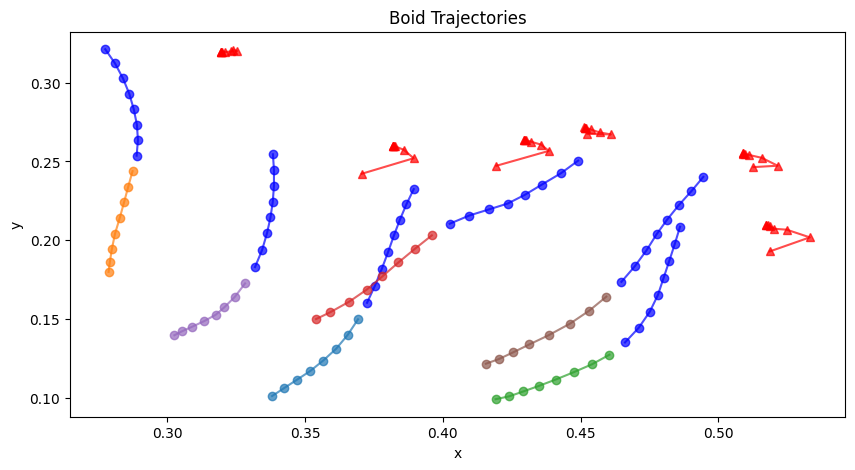

Testing:   0%|          | 2/1985 [00:00<05:46,  5.72it/s]


KeyboardInterrupt: 

In [25]:
test_generator_plot(test_dataset, generator, horizon=generator.out_steps)

In [ ]:
class GraphSeqDiscriminator(torch.nn.Module):
    def __init__(self, node_feat_dim, enc_hidden_dim, enc_latent_dim):
        super(GraphSeqDiscriminator, self).__init__()

        self.encoder = Encoder(node_feat_dim, enc_hidden_dim, enc_latent_dim)
        self.linear = torch.nn.Linear(enc_latent_dim, 1)

    def forward(self, x, edge_index, edge_weight, h):
        z, h_enc_0 = self.encoder(x, edge_index, edge_weight, h)
        z = F.relu(z)

        # Apply global mean pooling across the node dimension (dim=0) to aggregate node features
        z_pooled = z.mean(dim=0)
        out = self.linear(z_pooled)
        out = torch.sigmoid(z_pooled)
        return out, h_enc_0

Epoch: 1/30


Testing: 100%|██████████| 1989/1989 [01:45<00:00, 18.78it/s]


Testing Loss:  0.2572775994071174


Training:  13%|█▎        | 1045/7988 [00:54<06:01, 19.19it/s]


KeyboardInterrupt: 